### GPU Available?

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

: 

### Data Pulling

In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

: 

In [3]:
#This part linkes the dataset in the drive to the google colab file
link = 'https://drive.google.com/file/d/1GEsalW5I7kD50HaBdUgUZSk1d3qBM1Z5/view?usp=sharing'
id = link.split('/')[-2]
downloaded = drive.CreateFile({'id' : id})
downloaded.GetContentFile('stockprizes.csv')

NameError: name 'downloaded' is not defined

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('stockprizes.csv')
df["DailyRet"] = 0
df["20DayRet"] = 0
df["20DayVol"] = 0
df["Z20DayRet"] = 0
df['Z20DayVol'] = 0
df['Date']= pd.to_datetime(df['Date'])
df_close = df[['Date', 'Index', 'Close']] 
df_close.info()
df_close = df_close.pivot_table(index = 'Date', columns = 'Index', values = 'Close').dropna(axis=1)
stocks_tickers = df_close.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591628 entries, 0 to 591627
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    591628 non-null  datetime64[ns]
 1   Index   591628 non-null  object        
 2   Close   591599 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.5+ MB


In [2]:
#Saving Trading Days
dates = df_close.index

#Saving Stocks
stocks = df_close.columns

# Feature Engineering

In [3]:
raw_df = df.drop(columns = ['Unnamed: 0']).set_index(['Date' , 'Index']).unstack(level = 1).stack(level = 0).unstack()
raw_df = raw_df.dropna(axis = 1)
for stock in stocks_tickers:
  #Calculate Daily Returns
  raw_df.loc[:, (stock, 'DailyRet')] = raw_df[stock]["Close"].pct_change()
  #Calculate 20-Day Returns
  raw_df.loc[:, (stock, '20DayRet')] = raw_df[stock]["Close"].pct_change(20)
  #Calculate Rolling 20 day volatility 
  roller = raw_df[stock]["DailyRet"].rolling(20)
  raw_df.loc[:, (stock, '20DayVol')] = roller.std(ddof=0)
  
  '''Normalize data with the rolling 252'''
  #Normalize 20 Day Returns 
  rolling_year_ret = raw_df[stock]["20DayRet"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayRet')] = (rolling_year_ret.mean().shift(1) - raw_df[stock]['20DayRet']) / rolling_year_ret.std(ddof=0).shift(1)
  #Normalize 20 Day Volatility
  rolling_year_vol = raw_df[stock]["20DayVol"].rolling(252)
  raw_df.loc[:, (stock, 'Z20DayVol')] = (rolling_year_vol.mean().shift(1) - raw_df[stock]['20DayVol']) / rolling_year_vol.std(ddof=0).shift(1) 

raw_df.head(5)  

Index             A                                                      \
           20DayRet 20DayVol   Adjusted      Close  DailyRet       High   
Date                                                                      
2002-11-18      NaN      NaN   8.323743   9.728183       NaN  10.071531   
2002-11-19      NaN      NaN  10.159863  11.874106  0.220588  12.210300   
2002-11-20      NaN      NaN  10.410803  12.167382  0.024699  12.303290   
2002-11-21      NaN      NaN  11.163611  13.047210  0.072310  13.261803   
2002-11-22      NaN      NaN  11.169734  13.054363  0.000548  13.412017   

Index                                                   ...        T  \
                  Low       Open      Volume Z20DayRet  ... 20DayVol   
Date                                                    ...            
2002-11-18   9.670959   9.799714   2996613.0       NaN  ...      NaN   
2002-11-19  10.515021  10.550787  18513155.0       NaN  ...      NaN   
2002-11-20  11.452074  11.866953   6616874.0       NaN  ...      NaN   
2002-11-21  12.439199  12.446352   7871020.0       NaN  ...      NaN   
2002-11-22  12.875536  13.054363   4724960.0       NaN  ...      NaN   

Index                                                                       \
            Adjusted      Close  DailyRet       High        Low       Open   
Date                                                                         
2002-11-18  4.537619  19.365559       NaN  19.667673  18.882175  19.214502   
2002-11-19  4.509303  19.244713 -0.006240  19.410875  18.935045  19.335346   
2002-11-20  4.636724  19.788521  0.028258  20.279455  19.040785  19.123867   
2002-11-21  4.863253  20.755287  0.048855  21.095165  19.728098  19.788521   
2002-11-22  4.875641  20.808157  0.002547  21.283989  20.475830  20.762840   

Index                                       
                Volume Z20DayRet Z20DayVol  
Date                                        
2002-11-18  10821052.0       NaN       NaN  
2002-11-19   8903238.0       NaN       NaN  
2002-11-20  12969639.0       NaN       NaN  
2002-11-21  14758231.0       NaN       NaN  
2002-11-22  10615435.0       NaN       NaN  

[5 rows x 1100 columns]

In [4]:
#DROP ROWS WITH NA vals 
full_feature_dataset = raw_df.dropna(axis=0)

In [5]:
full_features = raw_df[['Open', 'High', 'Low', 'Close', 'Adjusted', 'Volume', 'DailyRet', 'Z20DayRet', 'Z20DayVol']].columns.remove_unused_levels()

KeyError: "['Open' 'High' 'Low' 'Close' 'Adjusted' 'Volume' 'DailyRet' 'Z20DayRet'\n 'Z20DayVol'] not in index"

# Principal Component Analysis

In [6]:
full_feature_dataset.head()

Index              A                                                       \
            20DayRet  20DayVol   Adjusted      Close  DailyRet       High   
Date                                                                        
2003-12-17 -0.021246  0.016019  16.635254  19.442060 -0.010197  19.685265   
2003-12-18  0.004332  0.016875  17.026953  19.899857  0.023547  20.100143   
2003-12-19  0.027533  0.016454  17.131004  20.021460  0.006111  20.207439   
2003-12-22  0.043398  0.016640  17.363579  20.293276  0.013576  20.386267   
2003-12-23  0.020578  0.016239  17.302368  20.221745 -0.003525  20.314735   

Index                                                  ...         T  \
                  Low       Open     Volume Z20DayRet  ...  20DayVol   
Date                                                   ...             
2003-12-17  19.141630  19.678112  2362480.0  0.512653  ...  0.012303   
2003-12-18  19.313305  19.313305  3739370.0  0.309948  ...  0.012212   
2003-12-19  19.914164  20.185980  5827144.0  0.131322  ...  0.012174   
2003-12-22  19.914164  20.028612  2859469.0  0.010707  ...  0.012196   
2003-12-23  20.107296  20.171675  2761330.0  0.187924  ...  0.012374   

Index                                                                       \
            Adjusted      Close  DailyRet       High        Low       Open   
Date                                                                         
2003-12-17  4.777606  18.935045  0.011703  18.957705  18.738670  18.791540   
2003-12-18  4.823344  19.116314  0.009573  19.138973  18.927492  18.972811   
2003-12-19  4.810004  19.063444 -0.002766  19.327795  18.912388  19.184290   
2003-12-22  4.850023  19.222054  0.008320  19.222054  18.904835  19.033234   
2003-12-23  4.825250  19.123867 -0.005108  19.358006  19.025681  19.033234   

Index                                       
                Volume Z20DayRet Z20DayVol  
Date                                        
2003-12-17  11758841.0 -0.995490  1.159951  
2003-12-18  11449952.0 -1.156730  1.163700  
2003-12-19  18629739.0 -1.167849  1.159862  
2003-12-22  10245377.0 -1.211672  1.147321  
2003-12-23   9203786.0 -1.127273  1.112602  

[5 rows x 1100 columns]

In [7]:
full_feature_dataset = full_feature_dataset.to_numpy()
full_feature_dataset.shape

(4760, 1100)

### Performing PCA to Extract most useful features for the dataset

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# LSTM Stock Prediction

## Data Manipulation

In this section several steps are performed...
- Set our lookback/training window and horizon/testing window
- Create a training, validation, and test set
- Scale the data using MinMaxScaler
- Process data into arrays with ranges of dates from (lookback, t) and (t+1, horizon). T jumps by one day each time.

In [9]:
closing_prices = df_close.iloc[:full_feature_dataset.shape[0],:]

Creating train and test sets

In [10]:
from sklearn.model_selection import train_test_split
#Division of data
# df_close = df_close.to_numpy()
array_train, array_test = train_test_split(closing_prices, shuffle = False, test_size = .2)
PCA_train, PCA_test = train_test_split(full_feature_dataset, shuffle = False, test_size = .2)

In [11]:
print(array_train.shape)
print(PCA_train.shape)

(3808, 100)
(3808, 1100)


In [12]:
from sklearn.decomposition import PCA
pc3 = PCA()
temp = pc3.fit_transform(PCA_train)

Nearly all data is explained by 382 components

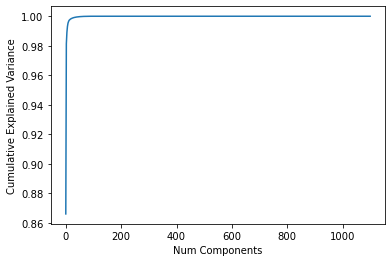

In [13]:
plt.plot(np.cumsum(pc3.explained_variance_ratio_))
plt.xlabel('Num Components')
plt.ylabel('Cumulative Explained Variance');

Scaling the Data

In [34]:
#Data with only closing prices
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scale = MinMaxScaler()
array_train = scl.fit_transform(array_train)
array_test  = scale.fit_transform(array_test) #[0,1]

#Full features dataset; reducing dimensionality here
from sklearn.decomposition import PCA
pcTrain_scl = MinMaxScaler()
pcTest_scl  = MinMaxScaler()
pcaTrain = PCA(n_components = 100)
pcaTest = PCA(n_components = 100)

PCA_train = pcTrain_scl.fit_transform(PCA_train)
PCA_train = pcaTrain.fit_transform(PCA_train)

PCA_test = pcTest_scl.fit_transform(PCA_test)
PCA_test = pcaTest.fit_transform(PCA_test)

In [35]:
print(array_train.shape)
print(PCA_train.shape)

(3808, 100)
(3808, 100)


Creating function to iteravely process data

In [36]:
#Get the data and splits in input X and output Y, by spliting in lookback number of past days as input X 
#and horizon number of coming days as Y.
def processData(data, lookback, horizon,num_companies,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -lookback - horizon +1, jump):
        X.append(data[i:(i+lookback)])
        Y.append(data[(i+lookback):(i+lookback+horizon)])
    return np.array(X),np.array(Y)

Setting lookback and horizon window sizes

In [37]:
num_companies = df_close.shape[1]
lookback = 252 #How many days of the past can the model see
horizon = 22 #How many days into the future are we trying to predict

Further splitting the train data into training and validation sets

In [38]:
# Formation of lookback dataframes and forward dataframes for training, and testing dataset
# to calculate accuracy

#Testing Data
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])

#Training/Validation Data
X_PCA, void = processData(PCA_train,lookback,horizon,num_companies)
void, y = processData(array_train,lookback,horizon,num_companies)
y = np.array([list(x.ravel()) for x in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_PCA, y, test_size=0.20, random_state=1)

In [39]:
8404/22
#Length y_train/test/validate / forward window == # of features

382.0

In [40]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#(Sample,Timestep,Features)

(2828, 252, 100)
(707, 252, 100)
(31, 252, 100)
(2828, 2200)
(707, 2200)
(31, 2200)


## Model Architecture + Training

Here, we can input the number or neurons on each layer, change the level of dropout, and set the specifications for early dropout. The model is then trained and the learning curve is plotted below.

In [41]:
from keras.models import Sequential, load_model
import tensorflow as tf
from keras.layers import LSTM,Dense,Activation,Attention,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import Regularizer
from keras import optimizers

#Model Architecture - Two LSTM layers with x neurons & y epochs
num_neurons_L1 = 800
num_neurons_L2 = 600
num_neurons_dense1 = 200
EPOCHS = 100

#Model
model = Sequential()

model.add(LSTM(num_neurons_L1,input_shape=(lookback,num_companies), return_sequences=True))
model.add(LSTM(num_neurons_L2,input_shape=(num_neurons_L1,1)))
model.add(Dense(horizon * num_companies, activation = 'relu'))
model.add(Dense(horizon * num_companies, activation = 'sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['accuracy'])

In [ ]:
# Early stopping severly *underfits* the data, we are going for better results

# early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=11, 
#     min_delta=0.000000001, 
#     mode='max'
# )

history = model.fit(X_train,y_train,epochs=EPOCHS,
                    validation_data=(X_validate,y_validate),
                    shuffle=False,batch_size=256, verbose=2)

Epoch 1/100
12/12 - 364s - loss: 0.0618 - accuracy: 0.0032 - val_loss: 0.0393 - val_accuracy: 0.0014 - 364s/epoch - 30s/step
Epoch 2/100
12/12 - 313s - loss: 0.0396 - accuracy: 0.0050 - val_loss: 0.0365 - val_accuracy: 0.0000e+00 - 313s/epoch - 26s/step
Epoch 3/100
12/12 - 349s - loss: 0.0405 - accuracy: 0.0011 - val_loss: 0.0371 - val_accuracy: 0.0014 - 349s/epoch - 29s/step
Epoch 4/100
12/12 - 347s - loss: 0.0407 - accuracy: 0.0025 - val_loss: 0.0375 - val_accuracy: 0.0014 - 347s/epoch - 29s/step
Epoch 5/100
12/12 - 401s - loss: 0.0407 - accuracy: 0.0018 - val_loss: 0.0377 - val_accuracy: 0.0014 - 401s/epoch - 33s/step
Epoch 6/100
12/12 - 2227s - loss: 0.0405 - accuracy: 0.0014 - val_loss: 0.0372 - val_accuracy: 0.0000e+00 - 2227s/epoch - 186s/step
Epoch 7/100
12/12 - 728s - loss: 0.0405 - accuracy: 0.0021 - val_loss: 0.0376 - val_accuracy: 0.0000e+00 - 728s/epoch - 61s/step
Epoch 8/100
12/12 - 861s - loss: 0.0401 - accuracy: 0.0021 - val_loss: 0.0368 - val_accuracy: 0.0000e+00 - 861

Plotting the learning curve - Loss

In [31]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

NameError: name 'history' is not defined

<Figure size 1080x720 with 0 Axes>

In [ ]:
plt.figure(figsize = (15,10))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='best')
plt.show()

: 

### Predicting Test Results

In [ ]:
X_test, void = processData(PCA_test,lookback,horizon,num_companies,horizon)
void, y_test = processData(array_test,lookback,horizon,num_companies,horizon) 
y_test = np.array([list(a.ravel()) for a in y_test])


Xt = model.predict(X_test)
Xt.shape

: 

### Un-scaling the data and returning data to original shape
Because the results were scaled to train the model, the output is non sensible until we return the data into its original form

In [ ]:
#Aux function 1
def do_inverse_transform(output_result,num_companies):
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scl.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

: 

In [ ]:
#Aux function 2
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[lista[j] for j in range(i,len(lista),num_companies)] for lista in raw_model_output])
    return np.array(matrix_prediction)

: 

In [ ]:
#Aux function 3
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

: 

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)
predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

: 

In [ ]:
Yt = do_inverse_transform(y_test, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

: 

### Prediction Results on Test Data - Plot

In [ ]:
plt.figure(figsize = (15,10))

companies_to_show = [2] 
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'AAPL', 'ABC', 'ABMD']
 
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

: 

In [ ]:
full_PCA = np.concatenate((PCA_train,PCA_test),axis = 0)

: 

In [ ]:
X_all,void = processData(full_PCA,lookback,horizon,num_companies,horizon)
void,y_all = processData(scl.fit_transform(df_close),lookback,horizon,num_companies,horizon)
y_all = np.array([list(a.ravel()) for a in y_all])

: 

In [ ]:
Xt = model.predict(X_all)
Xt.shape

: 

In [ ]:
Xt = do_inverse_transform(Xt, num_companies)

predictions = prediction_by_step_by_company(Xt, num_companies)
predictions.shape

: 

In [ ]:
Yt = do_inverse_transform(y_all, num_companies)

actuals = target_by_company(Yt, num_companies)
actuals.shape

: 

### Prediction Results on Full Data - Plot

In [ ]:
plt.figure(figsize = (40,10))

companies_to_show = [2] #Type a number between 0:4 to see 4 different companies
colors = ['r','g','c','m','y','k','w','b']
companies_names = ['A', 'B', 'C', 'D']

    
for id_company in companies_to_show:
    for i in range(0,len(predictions[id_company])):
        plt.plot([x + i*horizon for x in range(len(predictions[id_company][i]))], predictions[id_company][i], color=colors[id_company])
    plt.plot(0,predictions[id_company][0][0] ,color=colors[id_company], label='predict_{}'.format(companies_names[id_company])) #only to place the label

   

for id_company in companies_to_show:
    plt.plot(actuals[id_company], label='target_{}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

##QQ-plot

: 

# Stock Prices Predictions

In [ ]:
predicted_prices = np.zeros((predictions.shape[1]*predictions.shape[2],predictions.shape[0]))
# actual_prices = []

for i in range(predictions.shape[0]):
  counter = 0
  for j in range(predictions.shape[1]):
    for z in range(predictions.shape[2]):
      predicted_prices[counter, i] = predictions[i,j,z]
      counter+=1

print(counter)

: 

In [ ]:
actuals_prices = actuals[:,:4488].T

: 

In [ ]:
print(predicted_prices.shape)
print(actuals_prices.shape)
print(dates.shape)
#(lookback+1, )

: 

In [ ]:
(5027-lookback+1)-4488

: 

In [ ]:
# Need to remove certain days because we predict into the future. But, we aren't able to test these predicted days
# against actual days in our porfolio optimization

actual_prices = pd.DataFrame(data = actuals_prices, columns = stocks,index = dates[lookback+1:5028-287])
predicted_prices = pd.DataFrame(data = predicted_prices,columns=stocks, index = dates[lookback+1:5028-287])

: 

In [ ]:
actual_prices

: 

In [ ]:
predicted_prices

: 

In [ ]:
from google.colab import drive
drive.mount('drive')

: 

In [ ]:
predicted_prices.to_csv('PCA_Predicted_Prices1.csv')
!cp PCA_Predicted_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

: 

In [ ]:
actual_prices.to_csv('PCA_Actual_Prices1.csv')
!cp PCA_Actual_Prices1.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

: 